In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline




## Make up time series

$$y = 0 + 0.01t + 0.4sin(1\times\frac{2\pi t}{7}) + 0.2cos(1\times\frac{2\pi t}{7}) + 0.1sin(2\times\frac{2\pi t}{7}) + 0.3cos(2\times\frac{2\pi t}{7}) + 0.5sin(3\times\frac{2\pi t}{7}) + 0.7cos(3\times\frac{2\pi t}{7})$$

$$\text{coefficients} = [0, 0.01, 0.4, 0.2, 0.1, 0.3, 0.5, 0.2]$$

In [2]:
ds = pd.date_range(start='2010-01-01', end='2020-01-01').values
t = ds.astype(int)/(60*60*24*1e9)
t_weekly = 2*math.pi*t/7

y = 0.01*t 
y += 0.4*np.sin(1*t_weekly)+0.2*np.cos(1*t_weekly)
y += 0.10*np.sin(2*t_weekly)+0.3*np.cos(2*t_weekly)
y += 0.5*np.sin(3*t_weekly)+0.2*np.cos(3*t_weekly)
y += np.random.randn(t.shape[0])

In [3]:
data = pd.DataFrame({"ds": ds, "y":y})
data.head()

,ds,y
0,2010-01-01,148.149350
1,2010-01-02,146.725378
2,2010-01-03,146.473805
3,2010-01-04,147.011965
4,2010-01-05,147.497114


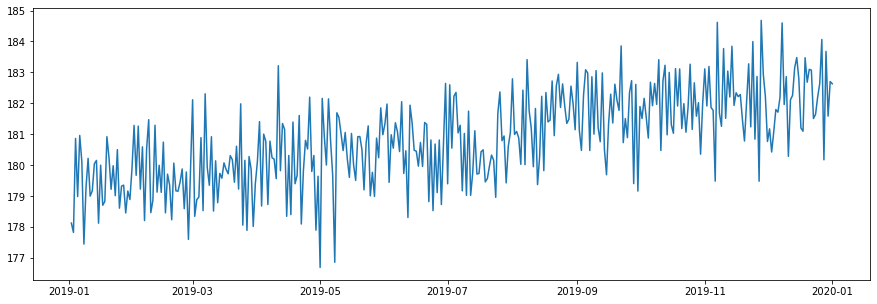

In [4]:
plt.figure(figsize=(15,5))
plt.plot(ds[-365:], y[-365:])
plt.show()

In [2]:
# lots of code taken from 
# https://towardsdatascience.com/linear-regression-with-pytorch-eb6dedead817
import torch
import torch.nn as nn
import torch.optim as optim
import math

class Chronos(nn.Module):
    
    def __init__(self, 
                 criterion=None,
                 optimizer="adam",
                 weekly_seasonality=0,
                 epochs=200):
        super(Chronos, self).__init__()
        pyro.set_rng_seed(1)
        
        self.optimizer_name = optimizer
        
        self.criterion = criterion
        if (self.criterion is None):
            self.criterion = nn.MSELoss()
            
        self.weekly_seasonality = weekly_seasonality
        self.epochs = epochs
    
        
    def forward(self, X):
        out = self.linear(X)
        return out.view(-1, 1)
    
    def backward(self, X, y):
        inputs = torch.from_numpy(X)
        labels = torch.from_numpy(y).view(-1,1)
        self.optim.zero_grad()
        
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        
        loss.backward()
        self.optim.step()
        
        return loss
    
    def _prepare_data_from_date(self, X):
        #X.loc[: ,'ts'] = 0
        X.loc[: ,'ts'] = X['ds'].astype(np.int64)/(60*60*24*1e9)

        for o in range(1, self.weekly_seasonality+1):
            #X.loc[:, f'w_sin_{o}'] = 0.0
            #X.loc[:, f'w_cos_{o}'] = 0.0
            X.loc[:, f'w_sin_{o}'] = np.sin(2*math.pi*o*X['ts']/7)
            X.loc[:, f'w_cos_{o}'] = np.cos(2*math.pi*o*X['ts']/7)

        X = X.drop('ds', axis=1)
        
        return X
    
    def fit(self, Y):
        
        X = Y[['ds']].copy()
        X = self._prepare_data_from_date(X)
        y = Y['y'].copy()
        
        #X = np.c_[np.ones(X.shape[0]), X].astype(np.float32)
        
        # if X and y are pandas df
        X = X.values.astype(np.float32)
        y = y.values.astype(np.float32)
        
        
        self.feature_number = X.shape[1]
        self.target_number = 1 if len(y.shape) == 1 else y.shape[1]
        
        
        self.linear = nn.Linear(self.feature_number, self.target_number)
        
        if (self.optimizer_name == "adam"):
            self.optim = optim.Adam(self.parameters(), lr=0.1)
        else:
            raise ValueError(f'Optimizer {self.optimizer_name} is not recognized')
        
        
        for epoch in range(self.epochs):
            self.backward(X, y)
            
            
    def predict(self, X):
        
        
        X = X[['ds']].copy()
        X = self._prepare_data_from_date(X)
        X = X.values.astype(np.float32)
        X = torch.from_numpy(X)
        
        output = self(X)
        
        return output.detach().numpy()
        
        
        
    @property
    def coef_(self):
        
        return self.linear.weight.detach().numpy()
    
    @property
    def const_(self):
        return self.linear.bias.detach().numpy()

In [ ]:
my_model = Chronos(weekly_seasonality=3, 
                   epochs=2000)

In [ ]:
my_model.fit(data)

In [ ]:
my_model.coef_

In [ ]:
my_model.const_

In [ ]:
y_pred = my_model.predict(data)
y = data['y']

In [ ]:
plt.figure(figsize=(15,5))
max_points=100
plt.plot(data.iloc[-max_points:]['ds'], y_pred[-max_points:], label="prediction")
plt.plot(data.iloc[-max_points:]['ds'], y[-max_points:], label="true_censored")

plt.title(f'Sales')
plt.legend()
plt.show()

## USING Pyro

In [131]:
# lots of code taken from 
# https://towardsdatascience.com/linear-regression-with-pytorch-eb6dedead817
import torch
import torch.nn as nn
import pyro.optim as optim
import math
import time
import pyro
import pyro.distributions as dist
from pyro.nn import PyroSample
from pyro.nn import PyroModule
from pyro.infer.autoguide import AutoDiagonalNormal, AutoMultivariateNormal, AutoDelta, init_to_mean

from pyro.infer import SVI, Trace_ELBO, Predictive


class Chronos(PyroModule):
    
    def __init__(self, 
                 weekly_seasonality=0,
                 yearly_seasonality=0,
                 epochs=200,
                 lr=0.1,
                 random_state=None):
        pyro.clear_param_store()
        super(Chronos, self).__init__()
        
        if (random_state is None):
            pyro.set_rng_seed(int(time.time()))
        else:
            pyro.set_rng_seed(random_state)
        
        self.weekly_seasonality = weekly_seasonality
        self.yearly_seasonality = yearly_seasonality
        self.learning_rate=lr
        self.epochs = epochs
    
    #######################################################
    def forward(self, X, y=None):
        
        sigma = 0.02
        sigma = pyro.sample("sigma", dist.Uniform(0., 1.))
        
        mean = self.linear(X).view(-1)
        
        with pyro.plate("data", X.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean
    
    #######################################################
    def _prepare_data_from_date(self, X):
        X.loc[: ,'ts'] = pd.to_datetime(X['ds']).astype(np.int64)/(60*60*24*1e9)
        

        for o in range(1, self.weekly_seasonality+1):
            X.loc[:, f'w_sin_{o}'] = np.sin(2*math.pi*o*X['ts']/7)
            X.loc[:, f'w_cos_{o}'] = np.cos(2*math.pi*o*X['ts']/7)
            
        for o in range(1, self.yearly_seasonality+1):
            X.loc[:, f'y_sin_{o}'] = np.sin(2*math.pi*o*X['ts']/365.25)
            X.loc[:, f'y_cos_{o}'] = np.cos(2*math.pi*o*X['ts']/365.25)

        X = X.drop('ds', axis=1)
        
        return X.values.astype(np.float32)
    
    #######################################################
    def fit(self, Y):
        
        X = Y[['ds']].copy()
        X = self._prepare_data_from_date(X)

        y = Y['y'].values.astype(np.float32)
        
        
        
        self.feature_number = X.shape[1]
        self.target_number = 1 if len(y.shape) == 1 else y.shape[1]
        
        
        # change the linear layers to be a learnable distribution collection
        self.linear = PyroModule[nn.Linear](self.feature_number, 
                                            self.target_number)
        
        self.linear.weight = PyroSample(dist.Normal(0., 1.).expand([self.target_number,
                                                                    self.feature_number]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0, 10.0).expand([self.target_number]).to_event(1))
        
        
        X = torch.from_numpy(X)
        y = torch.from_numpy(y)
        
        
        
        self.guide = AutoDiagonalNormal(self)
        #self.guide = AutoDelta(self)
        self.guide = AutoMultivariateNormal(self)
        
        self.optimizer = pyro.optim.ClippedAdam({"lr": self.learning_rate})
        self.inference = SVI(self, self.guide, self.optimizer, loss=Trace_ELBO())
        
        epoch_printout = self.epochs//10
        
        epoch_list = []
        losses_list = []
        
        pyro.clear_param_store()
        for epoch in range(self.epochs):
            # calculate the loss and take a gradient step
            loss = self.inference.step(X, y)
            normalized_loss = loss/X.shape[0]
            
            break_time = False
            if (epoch % epoch_printout == 0):
                print("[iteration %04d] loss: %.4f" % (epoch + 1, loss))
                
                y_pred = self.predict(Y)["y_hat"]
                
                
                MAE = np.mean(np.abs(y_pred - y.detach().numpy()))
                print(MAE)
                if (MAE < 1.0):
                    break_time = True
            
                
            epoch_list.append(epoch)
            losses_list.append(loss)
            if (break_time):
                break
            
            
        return pd.DataFrame({"epoch": epoch_list,
                             "loss": losses_list})
    #######################################################
    def predict(self, X, interval=0.9):
        
        
        
        X = X[['ds']].copy()
        X = self._prepare_data_from_date(X)

        X = torch.from_numpy(X)
        
        predictive = Predictive(self, 
                                guide=self.guide,
                                num_samples=1800,
                                return_sites=("_RETURN",))
        
        samples = predictive(X)
        
        interval_value = (1.0 - interval)/2
        
        
        stats = {}
        for key, values in samples.items():
            interval_number_bottom = int(values.shape[0]*interval_value)
            interval_number_top = int(values.shape[0]*(1.0-interval_value))
            
            
            stats = {"y_hat": torch.mean(values, axis=0).detach().numpy(),
                     "y_hat_std": torch.std(values, axis=0).detach().numpy(),
                     "y_lower": values.kthvalue(interval_number_bottom, axis=0)[0].detach().numpy(),
                     "y_upper": values.kthvalue(interval_number_top, axis=0)[0].detach().numpy()}
        #output = self(X)
        
            stats = pd.DataFrame(stats)
        return stats
        
        
    #######################################################
    @property
    def coef_(self):
        all_params = pyro.param('guide.loc').detach().numpy()
        
        # The first elements is the sigma we looked at
        coefficients_and_bias = all_params[-self.feature_number-1:]
        
        coefficients = coefficients_and_bias[:self.feature_number] # If there is a bias
                                                        # it's in the last spot
        return coefficients
    
    #######################################################
    @property
    def const_(self):
        all_params = pyro.param('guide.loc').detach().numpy()
        
        # The first elements is the sigma we looked at
        coefficients_and_bias = all_params[-self.feature_number-1:]
        
        bias = coefficients_and_bias[self.feature_number:]
        return bias

In [31]:
my_pyro_model = Chronos(weekly_seasonality=3,
                        epochs=20000,
                        lr=0.001)

In [ ]:
history = my_pyro_model.fit(data)

In [ ]:
pred = my_pyro_model.predict(data, interval=0.9)
pred.head()

In [ ]:
y_pred = pred["y_hat"]
y_lower = pred["y_lower"]
y_upper = pred["y_upper"]

y = data['y']

plt.figure(figsize=(15,5))

max_points = 365
plt.plot(data['ds'].iloc[-max_points:], 
         y_pred[-max_points:],
         label="prediction",
         c="blue")
plt.fill_between(data['ds'].iloc[-max_points:],
                 y_lower[-max_points:],
                 y_upper[-max_points:],
                 alpha=0.1,
                 color="blue")
plt.scatter(data['ds'].iloc[-max_points:], 
         y[-max_points:], 
         label="true_censored",
         c="red")

plt.title(f'Sales')
plt.legend()
plt.show()

In [ ]:
my_pyro_model.coef_

In [ ]:
my_model.coef_

In [ ]:
my_pyro_model.const_

In [132]:
prophet_df = pd.read_csv('data/prophetData.csv')
prophet_df.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


In [133]:
my_ch2 = Chronos(weekly_seasonality=3,
                 yearly_seasonality=10,
                 epochs=60000,
                 lr=0.001,
                 random_state=2)

In [134]:
my_ch2.fit(prophet_df);

[iteration 0001] loss: 18184720437.7988
1226.761
[iteration 6001] loss: 28484.3496
14.805563
[iteration 12001] loss: 130103.0520
12.444178
[iteration 18001] loss: 424237.4237
9.1012125


KeyboardInterrupt: 

In [ ]:
pred = my_ch2.predict(prophet_df, interval=0.95)
#pred += 4
pred.head()


In [ ]:
plt.figure(figsize=(15,5))


max_points = 3650
x = pd.to_datetime(prophet_df.iloc[-max_points:]['ds'])
plt.scatter(x, 
            prophet_df.iloc[-max_points:]['y'], 
            c="blue", 
            label="true")
plt.plot(x, 
         pred.iloc[-max_points:]['y_hat'], 
         c="red", 
         label="prediction")
plt.fill_between(x,
                 pred.iloc[-max_points:]['y_lower'],
                 pred.iloc[-max_points:]['y_upper'],
                 color="red",
                 alpha=0.1)
plt.legend()
plt.show()

In [ ]:
np.mean(np.abs(pred['y_hat'] - prophet_df['y']))